#               Forearm Keypoint Detection

## Importing Libraries and models

In [ ]:
pip install -r requirements.txt

In [1]:
import cv2
from keras.models import load_model
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from skimage.transform import resize

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
model = load_model('new_Mae.h5')


2023-06-26 21:45:25.591582: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-26 21:45:25.591604: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-06-26 21:45:25.591609: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-06-26 21:45:25.591671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-26 21:45:25.592135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def convert_tattoo_to_rgba(image_array, alpha=255):
    # Check if the input image is already in RGBA format
    if image_array.shape[2] == 4:
        return image_array

    # Create an alpha channel with the specified value
    alpha_channel = np.full((image_array.shape[0], image_array.shape[1], 1), alpha, dtype=np.uint8)

    # Identify white pixels
    white_pixels = np.all(image_array == [1., 1., 1.], axis=-1)
    black_pixels = np.all(image_array == [0., 0., 0.], axis=-1)

    # Set alpha to 0 for white pixels
    alpha_channel[white_pixels] = 0
    alpha_channel[black_pixels] = int(0.8 * alpha)

    # Concatenate the alpha channel with the RGB image
    rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

    return rgba_array


In [5]:
def overlay_images(background, overlay):
    # Create a copy of the background image to modify
    result = background.copy()

    # Resize the overlay image to match the background shape
    overlay_resized = overlay[:background.shape[0], :background.shape[1]]

    # Normalize the alpha values to range between 0 and 1
    overlay_alpha = overlay_resized[..., 3] / 255.0

    # Compute the weighted overlay using alpha blending
    result_alpha = 1 - (1 - overlay_alpha) * (1 - result[..., 3] / 255.0)
    result_alpha = np.clip(result_alpha, 0, 1)

    result[..., :3] = overlay_alpha[..., None] * overlay_resized[..., :3] + (1 - overlay_alpha[..., None]) * result[..., :3]
    result[..., 3] = result_alpha * 255

    return result


In [4]:

# Define the crop function
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image


# tattoo preprocessing

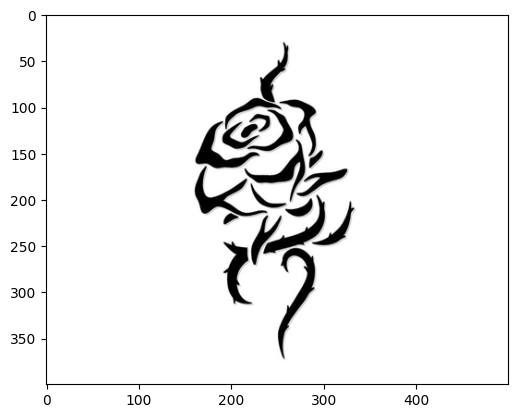

In [12]:
from PIL import Image
import numpy as np

# Load the tattoo image
tattoo_image = Image.open("/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/Testing_Tattoo_Images/rose.jpg")

width = 500 #change these values for preferred size 
height = 400

scaled_tattoo = tattoo_image.resize((width,height))
plt.imshow(scaled_tattoo)

In [13]:

# Create a white background image
background_color = (255, 255, 255)  # White color in RGB
background_image = Image.new("RGB", (400, 800), background_color)

# Create a blank canvas with the desired dimensions
canvas = Image.new("RGB", (400, 800), background_color)

# Calculate the position to place the image at the center of the canvas
x = (canvas.width - scaled_tattoo.width) // 2
y = (canvas.height - scaled_tattoo.height) // 2

# Overlay the image onto the canvas using PIL
canvas.paste(scaled_tattoo, (x, y))

# Convert the final image to a NumPy array
image_array = np.array(canvas)


In [14]:
from skimage.transform import resize

# Ensure image is within [0, 1] range
image_array = image_array / 255.0

resized_image = resize(image_array, (800, 320, 3), mode='constant')

# If you want to display or save the image using cv2 or matplotlib, you might need to scale it back to [0, 255]



In [15]:
# Define the threshold value
threshold = 0.5

# Binarize the image array
binarized_image_array = np.where(resized_image > threshold, 0., 1.)


In [16]:
import cv2
tl = (70, 0)
bl = (0, 800)
tr = (250, 0)
br = (320, 800)
pts1 = np.float32([tl, bl, tr, br])
threshold = 0.5




In [17]:

# Create a VideoCapture object
cap = cv2.VideoCapture(2)  # 0 is usually the built-in webcam
# codec = 0x47504A4D  # MJPG
# camera.set(cv2.CAP_PROP_FPS, 30.0)
# camera.set(cv2.CAP_PROP_FOURCC, codec)
# camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
# camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)


try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_frame) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)
# ... Your previous code up to model.predict ...

        predictions = model.predict(image_batch)





        # Reshape the predicted keypoints array to a (4, 2) matrix
        predicted_keypoints = predictions.reshape((4, 2))

        pts2 = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]], [predicted_keypoints[3][0], predicted_keypoints[3][1]], [predicted_keypoints[1][0], predicted_keypoints[1][1]], [predicted_keypoints[2][0], predicted_keypoints[2][1]]])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        transformed_frame = cv2.warpPerspective(binarized_image_array, matrix, (720, 1280))
        new_one = np.where(transformed_frame > threshold, 0., 1.) ##invert colours
        image_with_alpha = convert_tattoo_to_rgba(new_one)


        # Convert the keypoints to integers
        predicted_keypoints = predicted_keypoints.astype(int)
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)


        # Copy the frame so you don't modify the original
        drawn_frame = cropped_frame_rgb.copy()
        drawn_frames = convert_tattoo_to_rgba(drawn_frame)
        overlaid_image = overlay_images(drawn_frames, image_with_alpha)



        # Plot the keypoints
        for i in range(predicted_keypoints.shape[0]):
            x = predicted_keypoints[i][0]
            y = predicted_keypoints[i][1]
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            cv2.circle(overlaid_image, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

        # Display the resulting frame
        cv2.imshow('frame', overlaid_image)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()

Asked for all format descriptions...
[setting] Setting kCMIODevicePropertyDeviceMaster to 45831
[setting] Setting kCMIOStreamPropertyFormatDescription
Got new format : 1920x1080
Asked for all format descriptions...
[setting] Setting kCMIODevicePropertyDeviceMaster to -1
[setting] Setting kCMIODevicePropertyDeviceMaster to 45831
[setting] Setting kCMIODevicePropertyDeviceMaster to -1
Asked for all format descriptions...
1/1 [==============================] - 0s 15ms/step
[RemoteFrameSource] Releasing RemoteFrameSource


## live keypoints


In [5]:

# Create a VideoCapture object
cap = cv2.VideoCapture(2)  # 0 is usually the built-in webcam
# codec = 0x47504A4D  # MJPG
# camera.set(cv2.CAP_PROP_FPS, 30.0)
# camera.set(cv2.CAP_PROP_FOURCC, codec)
# camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
# camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)


try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_frame) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)
# ... Your previous code up to model.predict ...

        predictions = model.predict(image_batch)

        # Reshape the predicted keypoints array to a (4, 2) matrix
        predicted_keypoints = predictions.reshape((4, 2))

        # Convert the keypoints to integers
        predicted_keypoints = predicted_keypoints.astype(int)
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)


        # Copy the frame so you don't modify the original
        drawn_frame = cropped_frame_rgb.copy()

        # Plot the keypoints
        for i in range(predicted_keypoints.shape[0]):
            x = predicted_keypoints[i][0]
            y = predicted_keypoints[i][1]
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            cv2.circle(drawn_frame, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

        # Display the resulting frame
        cv2.imshow('frame', drawn_frame)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()

Asked for all format descriptions...
[setting] Setting kCMIODevicePropertyDeviceMaster to 88269
[setting] Setting kCMIOStreamPropertyFormatDescription
Got new format : 1920x1080
Asked for all format descriptions...
[setting] Setting kCMIODevicePropertyDeviceMaster to -1
[setting] Setting kCMIODevicePropertyDeviceMaster to 88269
[setting] Setting kCMIODevicePropertyDeviceMaster to -1
Asked for all format descriptions...
1/1 [==============================] - 0s 240ms/step


2023-06-26 21:45:50.611604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
[RemoteFrameSource] Releasing RemoteFrameSource


: 

## Tattoo inferencing 

In [8]:

# Load the tattoo image outside the loop
tattoo_image = Image.open("/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/Testing_Tattoo_Images/rose.jpg")
# Define the threshold value
threshold = 0.5
# Preprocess tattoo image outside the loop
width = 500
height = 400
scaled_tattoo = tattoo_image.resize((width, height))
canvas = Image.new("RGB", (400, 800), (255, 255, 255)) # white background
x = (canvas.width - scaled_tattoo.width) // 2
y = (canvas.height - scaled_tattoo.height) // 2
canvas.paste(scaled_tattoo, (x, y))
image_array = np.array(canvas)
image_array = image_array / 255.0
resized_image = resize(image_array, (800, 320, 3), mode='constant')
binarized_image_array = np.where(resized_image > threshold, 0., 1.)

# Now start the video capture
cap = cv2.VideoCapture(0)

try:
    while True:
        # Your code up to model.predict(image_batch)
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_frame) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)
# ... Your previous code up to model.predict ...

        predicted_keypoints = model.predict(image_batch)
        predicted_keypoints_reshaped = predicted_keypoints.reshape(-1, 2)



        # Warping the tattoo image according to predicted keypoints
        pts1 = np.float32([[0, 0], [0, height], [width, 0], [width, height]])
        pts2 = np.float32(predicted_keypoints_reshaped)
        matrix = cv2.getPerspectiveTransform(pts1, pts2)


        transformed_tattoo = cv2.warpPerspective(binarized_image_array, matrix, (720, 1280))

        # Convert the tattoo to RGBA
        tattoo_with_alpha = convert_tattoo_to_rgba(transformed_tattoo)

        # Convert the frame to RGBA
        frame_rgba = convert_tattoo_to_rgba(cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR))

        # Overlay the tattoo onto the frame
        overlaid_frame = overlay_images(frame_rgba, tattoo_with_alpha)

        # Convert back to BGR for cv2.imshow
        overlaid_frame_bgr = cv2.cvtColor(overlaid_frame.astype(np.uint8), cv2.COLOR_RGBA2BGR)

        # Display the resulting frame
        cv2.imshow('frame', overlaid_frame_bgr)

        # If 'q' is pressed on the keyboard, break from the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 12ms/step


## Random testing

In [ ]:


camera = cv2.VideoCapture(0)

codec = 0x47504A4D  # MJPG
camera.set(cv2.CAP_PROP_FPS, 30.0)
camera.set(cv2.CAP_PROP_FOURCC, codec)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while (1):
    retval, im = camera.read(0)
    cv2.imshow("image", im)

    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break

camera.release()
cv2.destroyAllWindows()

In [7]:


# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

while True:
    # Read frame from the camera
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow("Video", frame)

    # Wait for the 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close any open windows
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

In [6]:

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

while True:
    # Read frame from the camera
    ret, frame = cap.read()

    # Print the values of ret and frame
    print("ret:", ret)
    print("frame shape:", frame.shape if frame is not None else None)

    # Display the frame
    cv2.imshow("Video", frame)

    # Wait for the 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close any open windows
cap.release()
cv2.destroyAllWindows()



In [7]:

# Create a VideoCapture object
cap = cv2.VideoCapture(1)  # 0 is usually the built-in webcam
# codec = 0x47504A4D  # MJPG
# camera.set(cv2.CAP_PROP_FPS, 30.0)
# camera.set(cv2.CAP_PROP_FOURCC, codec)
# camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
# camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)


try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_frame) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)
# ... Your previous code up to model.predict ...

        predictions = model.predict(image_batch)

        # Reshape the predicted keypoints array to a (4, 2) matrix
        predicted_keypoints = predictions.reshape((4, 2))

        # Convert the keypoints to integers
        predicted_keypoints = predicted_keypoints.astype(int)
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)


        # Copy the frame so you don't modify the original
        drawn_frame = cropped_frame_rgb.copy()
        drawn_frames = convert_tattoo_to_rgba(drawn_frame)

        # Plot the keypoints
        for i in range(predicted_keypoints.shape[0]):
            x = predicted_keypoints[i][0]
            y = predicted_keypoints[i][1]
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            cv2.circle(drawn_frames, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

        # Display the resulting frame
        cv2.imshow('frame', drawn_frames)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()

Changed waitThread to realtime priority!
Asked for all format descriptions...
1/1 [==============================] - 0s 232ms/step


2023-06-25 23:11:38.804422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
